# Import Libraries

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision.models as models

from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetClassifier
from skorch.helper import predefined_split
from skorch.callbacks import EarlyStopping

import wandb
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# GPU

In [2]:
USE_GPU = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


# Load Dataset

In [3]:
# Root directory for dataset
dataroot = "./Dataset/"

# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 128

# All images will be resized to this size using a transformer
image_size = 32

# Number of channels in the training images
num_channels = 3

# Number of classes in the dataset
num_classes = 5

In [4]:
transform = transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ])

train_reader = dset.ImageFolder(root=dataroot+'train/', transform=transform)
train_loader = DataLoader(train_reader, batch_size=batch_size,
                          shuffle=True, num_workers=workers)

val_reader = dset.ImageFolder(root=dataroot+'valid/', transform=transform)
val_loader = DataLoader(val_reader, batch_size=batch_size,
                          num_workers=workers)

test_reader = dset.ImageFolder(root=dataroot+'test/', transform=transform)
test_loader = DataLoader(test_reader, batch_size=batch_size,
                         num_workers=workers)

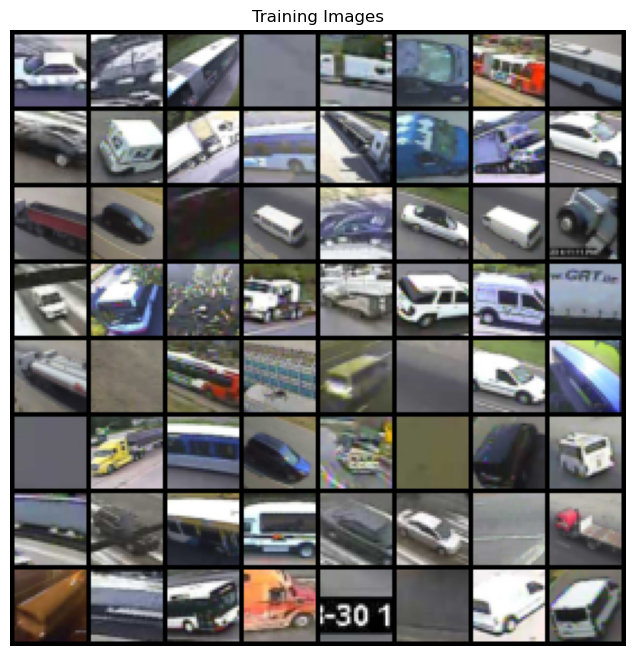

In [5]:
sample_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(sample_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

# Helper Functions

In [6]:
def check_accuracy(loader, model, validation=True, verbose=True):
    if verbose:
        if validation:
            print('Checking accuracy on validation set:')
        else:
            print('Checking accuracy on test set:')
        
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            
        acc = float(num_correct) / num_samples
        if verbose:
            print('Got %d / %d correct (%.2f %%)' % (num_correct, num_samples, 100*acc))
    
    return acc

In [7]:
def train_model(model, optimizer, epochs=1, print_every=50, use_wandb=False):

    model = model.to(device=device)
    criterion = nn.CrossEntropyLoss()

    train_loss_history, val_loss_history = [], []
    train_acc_history, val_acc_history = [], []

    for e in range(epochs):
        loss_train = []
        for t, (x, y) in enumerate(train_loader):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = criterion(scores, y)       
            loss_train.append(loss.cpu().detach().numpy())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if print_every == -1: # print at end of epoch
                if t == len(train_loader)-1:
                    print('Epoch %d / %d -> Loss = %.4f' %
                          (e+1, epochs, loss.item()))
                    acc_val = check_accuracy(val_loader, model)
                    print(40*'-')
            elif t % print_every == 0: # print at end of iteration
                print('Epoch %d / %d - Iteration %d / %d -> Loss = %.4f' %
                      (e+1, epochs, t, len(train_loader)-1, loss.item()))
                acc_val = check_accuracy(val_loader, model)
                print(40*'-')
                
        # Calculate loss for plotting
        with torch.no_grad():
            loss_val = []
            for x_val, y_val in val_loader:
                x_val = x_val.to(device=device, dtype=dtype)
                y_val = y_val.to(device=device, dtype=torch.long)
                scores_val = model(x_val)
                loss_val.append(criterion(scores_val, y_val).cpu().detach().numpy())
                
        train_loss_history.append(np.mean(loss_train))
        val_loss_history.append(np.mean(loss_val))
        
        train_acc_history.append(check_accuracy(train_loader, model, verbose=False))
        val_acc_history.append(acc_val)
        
        # W&B log
        if use_wandb:
            wandb.log({'train loss': train_loss_history[-1], 'epoch': e})
            wandb.log({'valid loss': val_loss_history[-1], 'epoch': e})
            wandb.log({'train acc': train_acc_history[-1], 'epoch': e})
            wandb.log({'valid acc': val_acc_history[-1], 'epoch': e})

    print('Final loss = %.4f' % (loss.item()))
    check_accuracy(val_loader, model)
    print(40*'-')
    check_accuracy(test_loader, model, validation=False)
    
    # Plot loss and accuracy history
    plt.figure(figsize=(10, 4))
    e_range = range(1, epochs+1)
    
    plt.subplot(1, 2, 1)
    plt.plot(e_range, val_loss_history)
    plt.plot(e_range, train_loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['validation','train'])
    
    plt.subplot(1, 2, 2)
    plt.plot(e_range, val_acc_history)
    plt.plot(e_range, train_acc_history)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['validation','train'])
    
    plt.show()

# Underfit Model

In [21]:
learning_rate, weight_decay = 3e-4, 2e-4

underfit_model = nn.Sequential(
    nn.Conv2d(in_channels=num_channels, out_channels=4, kernel_size=5, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.Flatten(),
    nn.Linear(in_features=8*30*30, out_features=num_classes)
)

optimizer = optim.Adam(underfit_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

Epoch 1 / 5 - Iteration 0 / 118 -> Loss = 1.6160
Checking accuracy on validation set:
Got 1202 / 5000 correct (24.04 %)
----------------------------------------
Epoch 1 / 5 - Iteration 50 / 118 -> Loss = 1.2670
Checking accuracy on validation set:
Got 2854 / 5000 correct (57.08 %)
----------------------------------------
Epoch 1 / 5 - Iteration 100 / 118 -> Loss = 0.9562
Checking accuracy on validation set:
Got 3194 / 5000 correct (63.88 %)
----------------------------------------
Epoch 2 / 5 - Iteration 0 / 118 -> Loss = 0.9989
Checking accuracy on validation set:
Got 3222 / 5000 correct (64.44 %)
----------------------------------------
Epoch 2 / 5 - Iteration 50 / 118 -> Loss = 0.8470
Checking accuracy on validation set:
Got 3297 / 5000 correct (65.94 %)
----------------------------------------
Epoch 2 / 5 - Iteration 100 / 118 -> Loss = 0.8878
Checking accuracy on validation set:
Got 3325 / 5000 correct (66.50 %)
----------------------------------------
Epoch 3 / 5 - Iteration 0 / 

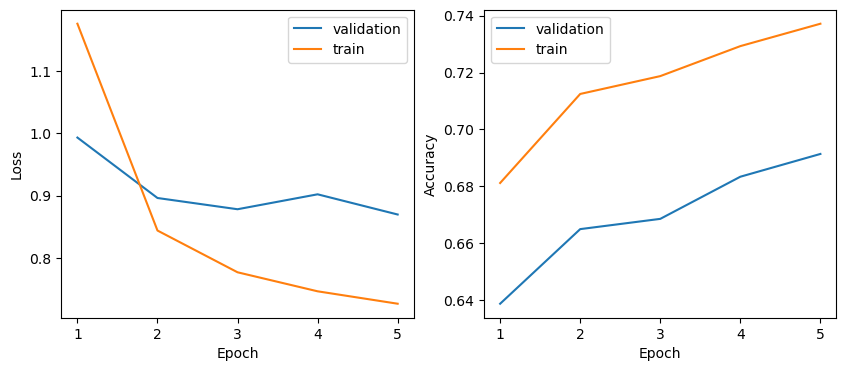

In [22]:
train_model(underfit_model, optimizer, epochs=5)

# Underfitting Reasons

- Lack of complexity
- Incorrect hyperparameters
- Low epochs

# Overfit Model

In [23]:
learning_rate, weight_decay = 3e-4, 2e-4

overfit_model = nn.Sequential(
    nn.Conv2d(in_channels=num_channels, out_channels=4, kernel_size=5, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=4, out_channels=8, kernel_size=5, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=7, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.Flatten(),
    nn.Linear(in_features=32*24*24, out_features=1024),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=1024, out_features=256),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=256, out_features=32),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=32, out_features=num_classes),
)

optimizer = optim.Adam(overfit_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

Epoch 1 / 10 - Iteration 0 / 118 -> Loss = 1.6122
Checking accuracy on validation set:
Got 1000 / 5000 correct (20.00 %)
----------------------------------------
Epoch 1 / 10 - Iteration 50 / 118 -> Loss = 1.4125
Checking accuracy on validation set:
Got 2412 / 5000 correct (48.24 %)
----------------------------------------
Epoch 1 / 10 - Iteration 100 / 118 -> Loss = 1.1716
Checking accuracy on validation set:
Got 2893 / 5000 correct (57.86 %)
----------------------------------------
Epoch 2 / 10 - Iteration 0 / 118 -> Loss = 0.9691
Checking accuracy on validation set:
Got 3097 / 5000 correct (61.94 %)
----------------------------------------
Epoch 2 / 10 - Iteration 50 / 118 -> Loss = 0.7291
Checking accuracy on validation set:
Got 3194 / 5000 correct (63.88 %)
----------------------------------------
Epoch 2 / 10 - Iteration 100 / 118 -> Loss = 0.8008
Checking accuracy on validation set:
Got 3262 / 5000 correct (65.24 %)
----------------------------------------
Epoch 3 / 10 - Iterati

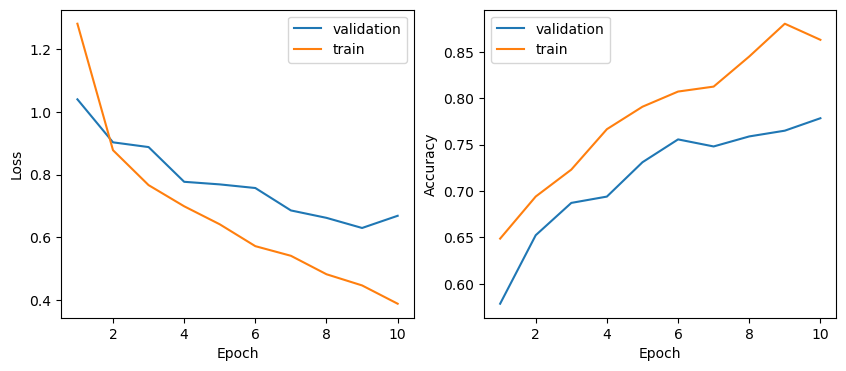

In [24]:
train_model(overfit_model, optimizer, epochs=10)

# Overfitting Reasons

- Overly complex model
- Lack of regularization
- Early stopping

# Best Model

In [8]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=num_channels, out_channels=64, kernel_size=7, stride=2, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            
            nn.Conv2d(in_channels=256, out_channels=192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((3, 3))

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=192*3*3, out_features=256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=256, out_features=256),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=256, out_features=num_classes),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        
        return x

# Grid search for learning rate hyperparameter

## Wrapper class to use validation dataset in skorch

In [26]:
class ValidDataset(Dataset):
    def __init__(self):
        self.X = torch.stack([item[0] for item in val_reader])
        self.Y = torch.stack([torch.tensor(item[1], dtype=torch.long) for item in val_reader])

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

    def __len__(self):
        return len(self.X)

## Early stopping callback

In [27]:
early_stopping = EarlyStopping(monitor='valid_loss', patience=7, threshold = 0.001,
                               threshold_mode='rel', lower_is_better=True)

## Define model

In [28]:
best_model = NeuralNetClassifier(
    ConvNet,
    criterion=nn.CrossEntropyLoss,
    batch_size=batch_size,
    max_epochs=80,
    optimizer=optim.Adam,
    optimizer__weight_decay=2e-4,
    iterator_train__shuffle=True,
    train_split=predefined_split(ValidDataset()),
    device=device,
    callbacks=[early_stopping]
)

## Split dataset

In [30]:
X_train = torch.stack([item[0] for item in train_reader])
y_train = torch.stack([torch.tensor(item[1], dtype=torch.long) for item in train_reader])

## Params to search

In [31]:
params = {
    'lr': [7e-5, 9e-5, 1e-4, 3e-4, 5e-4, 7e-4]
}

## Training

In [32]:
grid_net = GridSearchCV(best_model, params, scoring='accuracy', verbose=3)
result = grid_net.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.5540       0.4266        1.4659  3.3879
      2        1.2747       0.4938        1.2704  3.0527
      3        1.0848       0.5532        1.0922  3.0549
      4        0.9925       0.6084        0.9743  3.0598
      5        0.8990       0.6426        0.9082  3.0631
      6        0.8216       0.6792        0.8365  3.0622
      7        0.7549       0.7120        0.7795  3.0645
      8        0.7108       0.7422        0.7268  3.0648
      9        0.6555       0.7408        0.7111  3.1023
     10        0.6253       0.7626        0.6567  3.1177
     11        0.6020       0.7762        0.6166  3.1222
     12        0.5462       0.7826        0.6354  3.1167
     13        0.5076       0.7866        0.6351  3.1222
     14        0.4745       0.8030        0.5747  3.1283
     15        0.4505       

     36        0.2567       0.8364        0.4890  3.1439
     37        0.2405       0.8512        0.4467  3.1397
     38        0.2363       0.8362        0.4969  3.1281
     39        0.2276       0.8556        0.4552  3.1294
     40        0.2243       0.8272        0.5524  3.1251
     41        0.2271       0.8364        0.5286  3.1240
     42        0.2027       0.8550        0.4635  3.1328
     43        0.2022       0.8474        0.5046  3.1211
Stopping since valid_loss has not improved in the last 7 epochs.
[CV 3/5] END ..........................lr=7e-05;, score=0.880 total time= 2.3min
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.5614       0.4324        1.4931  3.1271
      2        1.2528       0.5158        1.1628  3.1194
      3        1.0752       0.5534        1.0738  3.1240
      4        0.9927       0.5874        1.0064  3.1251
      5        0.9220       0.6144        1.0106  3.1234

     32        0.1823       0.8500        0.5261  3.1465
     33        0.1772       0.8572        0.4949  3.1532
     34        0.1690       0.8684        0.4217  3.1360
     35        0.1681       0.8708        0.4320  3.1159
     36        0.1556       0.8712        0.4538  3.1485
     37        0.1485       0.8598        0.5012  3.1299
     38        0.1455       0.8654        0.4842  3.1225
     39        0.1396       0.8652        0.4915  3.1292
     40        0.1340       0.8652        0.4764  3.1071
Stopping since valid_loss has not improved in the last 7 epochs.
[CV 1/5] END ..........................lr=9e-05;, score=0.846 total time= 2.1min
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.5324       0.4288        1.3657  3.1245
      2        1.2157       0.5038        1.1684  3.1198
      3        1.0603       0.5842        1.0194  3.1310
      4        0.9369       0.6642        0.9090  3.1094

     21        0.3286       0.8122        0.5628  3.1078
     22        0.3264       0.8138        0.5503  3.1123
     23        0.3108       0.7918        0.6166  3.1088
     24        0.2890       0.8326        0.5085  3.1055
     25        0.2838       0.8206        0.5440  3.0956
     26        0.2699       0.8362        0.5100  3.0994
     27        0.2657       0.8272        0.5450  3.1069
     28        0.2530       0.8386        0.5168  3.1099
     29        0.2413       0.8418        0.4854  3.1069
     30        0.2260       0.8374        0.5163  3.1062
     31        0.2196       0.8248        0.5587  3.1016
     32        0.2082       0.8376        0.5393  3.1088
     33        0.2043       0.8412        0.4975  3.1072
     34        0.1901       0.8298        0.5369  3.1059
     35        0.1838       0.8246        0.6133  3.1056
Stopping since valid_loss has not improved in the last 7 epochs.
[CV 4/5] END ..........................lr=9e-05;, score=0.883 total time= 1.9min

     20        0.3132       0.8418        0.5027  3.1714
     21        0.3073       0.8360        0.5007  3.1569
     22        0.3068       0.8488        0.4585  3.1316
     23        0.2878       0.8378        0.5276  3.1332
     24        0.2582       0.8452        0.4656  3.1401
     25        0.2573       0.8326        0.5461  3.1512
     26        0.2409       0.8442        0.4700  3.1240
     27        0.2415       0.8428        0.4780  3.1179
     28        0.2338       0.8474        0.5074  3.1163
Stopping since valid_loss has not improved in the last 7 epochs.
[CV 2/5] END .........................lr=0.0001;, score=0.868 total time= 1.5min
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.5296       0.4002        1.4231  3.1194
      2        1.2361       0.4740        1.2194  3.1141
      3        1.0847       0.6078        1.0101  3.1190
      4        0.9582       0.6464        0.9336  3.1326

      2        1.0240       0.6010        0.9743  3.0933
      3        0.8741       0.6556        0.8720  3.0966
      4        0.7701       0.7250        0.7514  3.0959
      5        0.6442       0.7394        0.7474  3.0971
      6        0.5839       0.7810        0.6187  3.0877
      7        0.5215       0.7932        0.6088  3.0847
      8        0.4638       0.7902        0.6524  3.0874
      9        0.4262       0.8222        0.5407  3.0977
     10        0.3921       0.8224        0.5365  3.0909
     11        0.3683       0.8276        0.5091  3.0978
     12        0.3264       0.8290        0.5146  3.0886
     13        0.2978       0.8384        0.4939  3.0893
     14        0.2902       0.8168        0.5855  3.0855
     15        0.2801       0.8474        0.4515  3.0920
     16        0.2434       0.8524        0.4382  3.0897
     17        0.2334       0.8532        0.4704  3.0950
     18        0.2113       0.8588        0.4418  3.0950
     19        0.2002       0.8

     15        0.2907       0.8418        0.4771  3.1066
     16        0.2785       0.8530        0.4480  3.1080
     17        0.2597       0.8594        0.4235  3.1077
     18        0.2258       0.8574        0.4357  3.1182
     19        0.2284       0.8574        0.4486  3.1265
     20        0.2146       0.8540        0.4472  3.1336
     21        0.1875       0.8686        0.4338  3.0912
     22        0.1798       0.8540        0.4811  3.1123
     23        0.1787       0.8600        0.4969  3.1129
Stopping since valid_loss has not improved in the last 7 epochs.
[CV 4/5] END .........................lr=0.0003;, score=0.875 total time= 1.2min
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.4356       0.4812        1.2073  3.1095
      2        1.0939       0.5764        1.0584  3.1164
      3        0.8912       0.6700        0.8956  3.1033
      4        0.7465       0.6986        0.8414  3.1195

      7        0.5455       0.7958        0.5886  3.0772
      8        0.5031       0.7910        0.5955  3.0744
      9        0.4566       0.7784        0.5838  3.0835
     10        0.4212       0.7988        0.5907  3.0890
     11        0.3881       0.8280        0.5069  3.0840
     12        0.3527       0.8330        0.5254  3.0960
     13        0.3339       0.8210        0.5122  3.1218
     14        0.3093       0.8320        0.5018  3.0832
     15        0.2889       0.8522        0.4407  3.0913
     16        0.2688       0.8396        0.5229  3.1659
     17        0.2632       0.8434        0.5126  3.1404
     18        0.2496       0.8598        0.4424  3.1357
     19        0.2407       0.8552        0.4733  3.1339
     20        0.2128       0.8598        0.4411  3.1203
     21        0.2050       0.8574        0.4443  3.1063
Stopping since valid_loss has not improved in the last 7 epochs.
[CV 3/5] END .........................lr=0.0005;, score=0.900 total time= 1.1min

     11        0.4116       0.8024        0.5544  3.0701
     12        0.3916       0.8352        0.4708  3.0717
     13        0.3597       0.8374        0.4873  3.0670
     14        0.3434       0.8458        0.4446  3.0708
     15        0.3238       0.8418        0.4644  3.0720
     16        0.2977       0.8444        0.4716  3.0685
     17        0.2912       0.8268        0.5070  3.0702
     18        0.2820       0.8348        0.4734  3.0707
     19        0.2762       0.8482        0.4641  3.0712
     20        0.2613       0.8498        0.4644  3.0652
     21        0.2402       0.8528        0.4423  3.0668
     22        0.2414       0.8342        0.5220  3.0727
     23        0.2299       0.8644        0.4474  3.0614
     24        0.2270       0.8630        0.4418  3.0642
     25        0.2040       0.8666        0.4329  3.0693
     26        0.1866       0.8638        0.4178  3.0648
     27        0.1998       0.8606        0.4517  3.0680
     28        0.1858       0.8

     17        0.2809       0.8054        0.6183  3.1063
     18        0.2549       0.8136        0.6060  3.0894
     19        0.2400       0.7920        0.6713  3.0873
     20        0.2326       0.8006        0.6337  3.0712
     21        0.2365       0.8180        0.5629  3.0729
     22        0.2093       0.8022        0.6705  3.0700
     23        0.2107       0.8066        0.6363  3.0666
     24        0.1983       0.8184        0.5573  3.0678
     25        0.2006       0.8036        0.6825  3.0695
     26        0.1950       0.8112        0.6141  3.0635
     27        0.1777       0.8130        0.6689  3.0617
     28        0.1732       0.8174        0.6113  3.0709
     29        0.1704       0.8106        0.7141  3.0849
     30        0.1597       0.8132        0.6850  3.0704
Stopping since valid_loss has not improved in the last 7 epochs.
[CV 5/5] END .........................lr=0.0007;, score=0.857 total time= 1.6min
  epoch    train_loss    valid_acc    valid_loss     dur

## Results

In [38]:
for i in range(1, 4):
    candidates = np.flatnonzero(result.cv_results_['rank_test_score'] == i)
    for candidate in candidates:
        print("Model with rank: {0}".format(i))
        print("Mean validation accuracy: {0:.3f} %".format(
              result.cv_results_['mean_test_score'][candidate]*100))
        print("Parameters: {0}".format(result.cv_results_['params'][candidate]))
        print()

Model with rank: 1
Mean validation accuracy: 87.093 %
Parameters: {'lr': 0.0005}

Model with rank: 2
Mean validation accuracy: 86.580 %
Parameters: {'lr': 0.0003}

Model with rank: 3
Mean validation accuracy: 86.560 %
Parameters: {'lr': 0.0007}



## Plot best model's loss

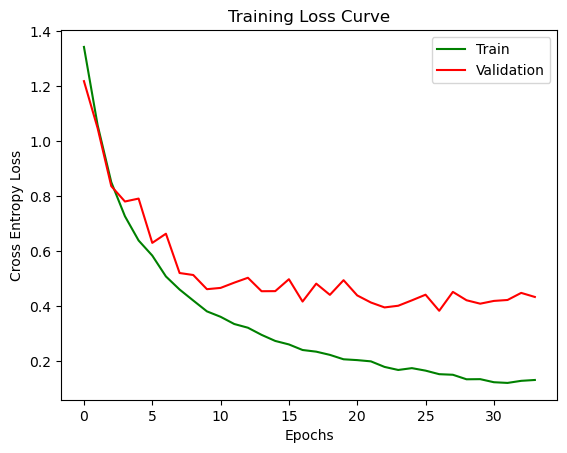

In [41]:
epochs = [i for i in range(len(grid_net.best_estimator_.history))]
train_loss = grid_net.best_estimator_.history[:,'train_loss']
valid_loss = grid_net.best_estimator_.history[:,'valid_loss']

plt.plot(epochs,train_loss,'g-');
plt.plot(epochs,valid_loss,'r-');
plt.title('Training Loss Curve');
plt.xlabel('Epochs');
plt.ylabel('Cross Entropy Loss');
plt.legend(['Train','Validation']);

## Check accuracy on test set

In [42]:
check_accuracy(test_loader, grid_net.best_estimator_.module_, validation=False)

Checking accuracy on test set:
Got 4298 / 5000 correct (85.96 %)


0.8596

# W&B

In [9]:
wandb.login()

wandb: Currently logged in as: mhmdrz. Use `wandb login --relogin` to force relogin


True

In [10]:
sweep_config = {
    'method': 'grid',
    'name': 'MIO_ConvNet',
    'metric': {
        'goal': 'minimize', 
        'name': 'valid loss'
        },
    'parameters': {
        'lr': {'values': [7e-5, 9e-5, 1e-4, 3e-4, 5e-4, 7e-4]}
     }
}

sweep_id = wandb.sweep(sweep_config, project='MIO ConvNet')

Create sweep with ID: g9ype2yr
Sweep URL: https://wandb.ai/mhmdrz/MIO%20ConvNet/sweeps/g9ype2yr


In [11]:
def train_wandb(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config

        wandb_model = ConvNet()
        optimizer = optim.Adam(wandb_model.parameters(), lr=config.lr, weight_decay=2e-4)
        train_model(wandb_model, optimizer, epochs=30, print_every=-1, use_wandb=True)

wandb: Agent Starting Run: 340vl8oj with config:
wandb: 	lr: 7e-05


Epoch 1 / 30 -> Loss = 1.1142
Checking accuracy on validation set:
Got 2302 / 5000 correct (46.04 %)
----------------------------------------
Epoch 2 / 30 -> Loss = 1.1094
Checking accuracy on validation set:
Got 2587 / 5000 correct (51.74 %)
----------------------------------------
Epoch 3 / 30 -> Loss = 0.7758
Checking accuracy on validation set:
Got 2801 / 5000 correct (56.02 %)
----------------------------------------
Epoch 4 / 30 -> Loss = 0.7952
Checking accuracy on validation set:
Got 3072 / 5000 correct (61.44 %)
----------------------------------------
Epoch 5 / 30 -> Loss = 0.7315
Checking accuracy on validation set:
Got 3338 / 5000 correct (66.76 %)
----------------------------------------
Epoch 6 / 30 -> Loss = 0.6743
Checking accuracy on validation set:
Got 3025 / 5000 correct (60.50 %)
----------------------------------------
Epoch 7 / 30 -> Loss = 0.4977
Checking accuracy on validation set:
Got 3654 / 5000 correct (73.08 %)
----------------------------------------
Epoch 

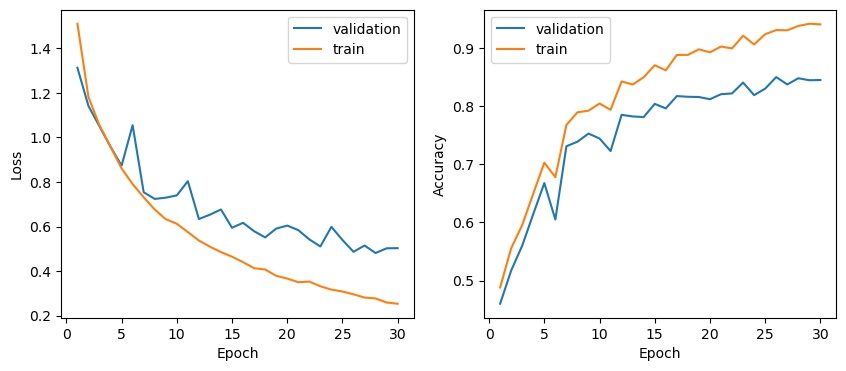

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train acc,▁▂▃▃▄▄▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇██████
train loss,█▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
valid acc,▁▂▃▄▅▄▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇██████
valid loss,█▇▆▅▄▆▃▃▃▃▄▂▂▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
epoch,29
train acc,0.94013
train loss,0.25377
valid acc,0.8446
valid loss,0.50314


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lfli7f8q with config:
wandb: 	lr: 9e-05


Epoch 1 / 30 -> Loss = 1.3886
Checking accuracy on validation set:
Got 2170 / 5000 correct (43.40 %)
----------------------------------------
Epoch 2 / 30 -> Loss = 1.1374
Checking accuracy on validation set:
Got 2781 / 5000 correct (55.62 %)
----------------------------------------
Epoch 3 / 30 -> Loss = 0.7976
Checking accuracy on validation set:
Got 3055 / 5000 correct (61.10 %)
----------------------------------------
Epoch 4 / 30 -> Loss = 0.9261
Checking accuracy on validation set:
Got 3388 / 5000 correct (67.76 %)
----------------------------------------
Epoch 5 / 30 -> Loss = 0.7590
Checking accuracy on validation set:
Got 3602 / 5000 correct (72.04 %)
----------------------------------------
Epoch 6 / 30 -> Loss = 0.7315
Checking accuracy on validation set:
Got 3647 / 5000 correct (72.94 %)
----------------------------------------
Epoch 7 / 30 -> Loss = 0.7712
Checking accuracy on validation set:
Got 3800 / 5000 correct (76.00 %)
----------------------------------------
Epoch 

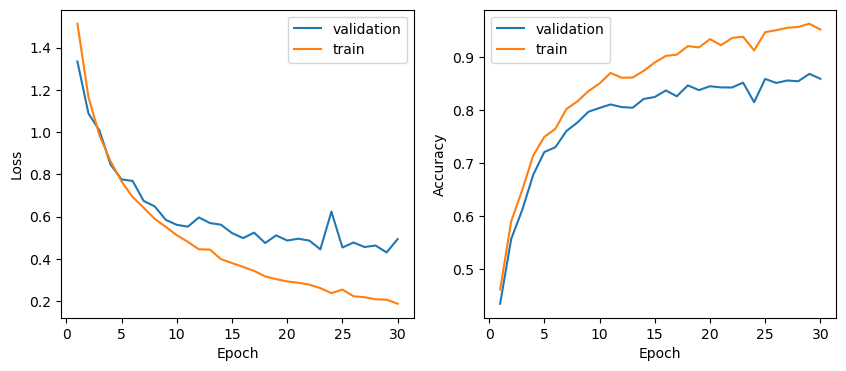

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train acc,▁▃▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█▇██▇██████
train loss,█▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
valid acc,▁▃▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇██████▇██████
valid loss,█▆▅▄▄▄▃▃▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▂▁▁▁▁▁▁
epoch,29
train acc,0.9516
train loss,0.18735
valid acc,0.8586
valid loss,0.49344


wandb: Agent Starting Run: ujup3rax with config:
wandb: 	lr: 0.0001


Epoch 1 / 30 -> Loss = 1.5367
Checking accuracy on validation set:
Got 2382 / 5000 correct (47.64 %)
----------------------------------------
Epoch 2 / 30 -> Loss = 0.8879
Checking accuracy on validation set:
Got 2717 / 5000 correct (54.34 %)
----------------------------------------
Epoch 3 / 30 -> Loss = 0.8244
Checking accuracy on validation set:
Got 3116 / 5000 correct (62.32 %)
----------------------------------------
Epoch 4 / 30 -> Loss = 0.6526
Checking accuracy on validation set:
Got 3430 / 5000 correct (68.60 %)
----------------------------------------
Epoch 5 / 30 -> Loss = 0.5835
Checking accuracy on validation set:
Got 3546 / 5000 correct (70.92 %)
----------------------------------------
Epoch 6 / 30 -> Loss = 0.7998
Checking accuracy on validation set:
Got 3755 / 5000 correct (75.10 %)
----------------------------------------
Epoch 7 / 30 -> Loss = 0.6787
Checking accuracy on validation set:
Got 3726 / 5000 correct (74.52 %)
----------------------------------------
Epoch 

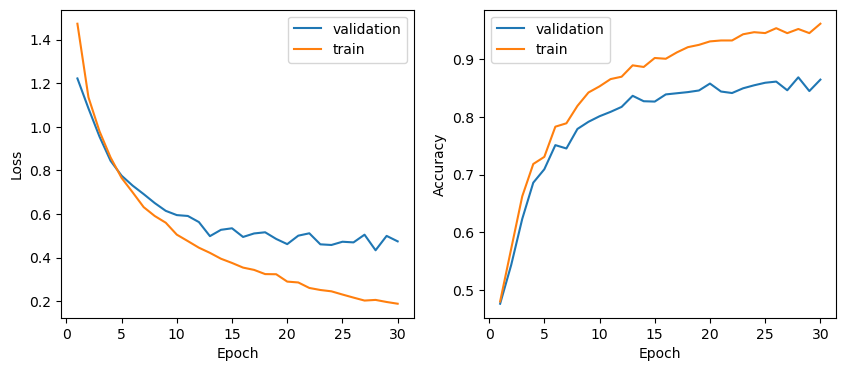

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train acc,▁▂▄▄▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇███████████
train loss,█▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
valid acc,▁▂▄▅▅▆▆▆▇▇▇▇▇▇▇▇██████████████
valid loss,█▇▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▂▁▂▁
epoch,29
train acc,0.9612
train loss,0.18823
valid acc,0.8644
valid loss,0.47436


wandb: Agent Starting Run: t4252i8f with config:
wandb: 	lr: 0.0003


Epoch 1 / 30 -> Loss = 0.9653
Checking accuracy on validation set:
Got 2523 / 5000 correct (50.46 %)
----------------------------------------
Epoch 2 / 30 -> Loss = 0.7386
Checking accuracy on validation set:
Got 3188 / 5000 correct (63.76 %)
----------------------------------------
Epoch 3 / 30 -> Loss = 1.0825
Checking accuracy on validation set:
Got 2962 / 5000 correct (59.24 %)
----------------------------------------
Epoch 4 / 30 -> Loss = 0.4424
Checking accuracy on validation set:
Got 3680 / 5000 correct (73.60 %)
----------------------------------------
Epoch 5 / 30 -> Loss = 0.5350
Checking accuracy on validation set:
Got 3717 / 5000 correct (74.34 %)
----------------------------------------
Epoch 6 / 30 -> Loss = 0.3480
Checking accuracy on validation set:
Got 3921 / 5000 correct (78.42 %)
----------------------------------------
Epoch 7 / 30 -> Loss = 0.6051
Checking accuracy on validation set:
Got 3953 / 5000 correct (79.06 %)
----------------------------------------
Epoch 

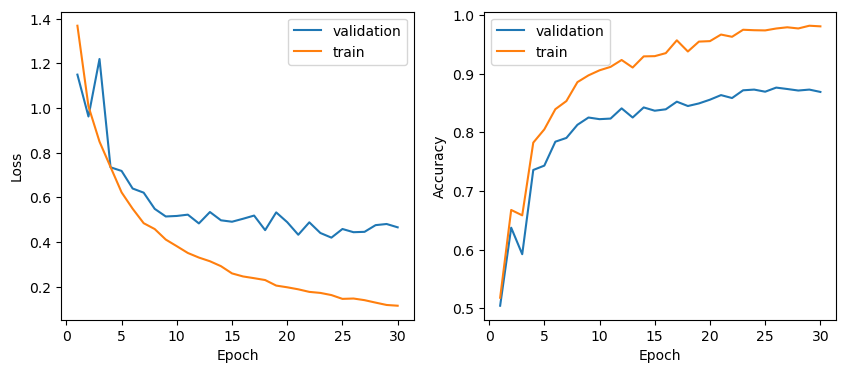

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train acc,▁▃▃▅▅▆▆▇▇▇▇▇▇▇▇▇█▇████████████
train loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
valid acc,▁▄▃▅▅▆▆▇▇▇▇▇▇▇▇▇█▇▇███████████
valid loss,▇▆█▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▂▁
epoch,29
train acc,0.9808
train loss,0.11426
valid acc,0.869
valid loss,0.46554


wandb: Agent Starting Run: zomcjs5o with config:
wandb: 	lr: 0.0005


Epoch 1 / 30 -> Loss = 1.2429
Checking accuracy on validation set:
Got 2538 / 5000 correct (50.76 %)
----------------------------------------
Epoch 2 / 30 -> Loss = 0.8625
Checking accuracy on validation set:
Got 3209 / 5000 correct (64.18 %)
----------------------------------------
Epoch 3 / 30 -> Loss = 0.6935
Checking accuracy on validation set:
Got 3520 / 5000 correct (70.40 %)
----------------------------------------
Epoch 4 / 30 -> Loss = 0.6284
Checking accuracy on validation set:
Got 3635 / 5000 correct (72.70 %)
----------------------------------------
Epoch 5 / 30 -> Loss = 0.8328
Checking accuracy on validation set:
Got 3725 / 5000 correct (74.50 %)
----------------------------------------
Epoch 6 / 30 -> Loss = 0.3352
Checking accuracy on validation set:
Got 3772 / 5000 correct (75.44 %)
----------------------------------------
Epoch 7 / 30 -> Loss = 0.5923
Checking accuracy on validation set:
Got 3705 / 5000 correct (74.10 %)
----------------------------------------
Epoch 

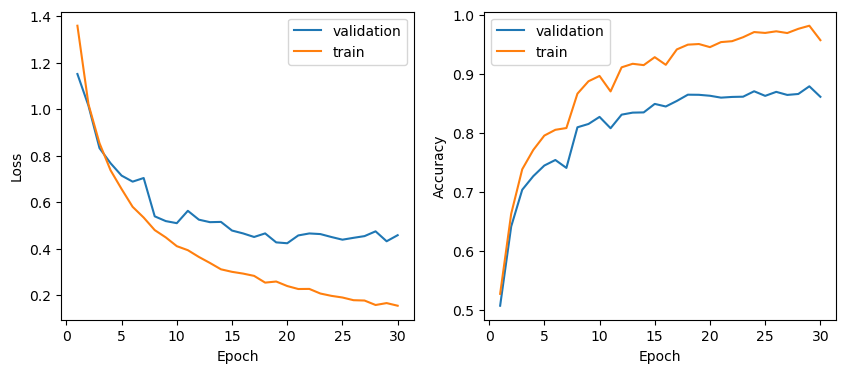

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train acc,▁▃▄▅▅▅▅▆▇▇▆▇▇▇▇▇▇██▇██████████
train loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
valid acc,▁▄▅▅▅▆▅▇▇▇▇▇▇▇▇▇██████████████
valid loss,█▇▅▄▄▄▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,29
train acc,0.95733
train loss,0.15425
valid acc,0.8614
valid loss,0.45776


wandb: Agent Starting Run: 8eo7ktj5 with config:
wandb: 	lr: 0.0007


Epoch 1 / 30 -> Loss = 1.1709
Checking accuracy on validation set:
Got 2468 / 5000 correct (49.36 %)
----------------------------------------
Epoch 2 / 30 -> Loss = 1.0336
Checking accuracy on validation set:
Got 3054 / 5000 correct (61.08 %)
----------------------------------------
Epoch 3 / 30 -> Loss = 0.5744
Checking accuracy on validation set:
Got 3486 / 5000 correct (69.72 %)
----------------------------------------
Epoch 4 / 30 -> Loss = 0.7732
Checking accuracy on validation set:
Got 3685 / 5000 correct (73.70 %)
----------------------------------------
Epoch 5 / 30 -> Loss = 0.4803
Checking accuracy on validation set:
Got 3848 / 5000 correct (76.96 %)
----------------------------------------
Epoch 6 / 30 -> Loss = 0.4191
Checking accuracy on validation set:
Got 3904 / 5000 correct (78.08 %)
----------------------------------------
Epoch 7 / 30 -> Loss = 0.4054
Checking accuracy on validation set:
Got 3985 / 5000 correct (79.70 %)
----------------------------------------
Epoch 

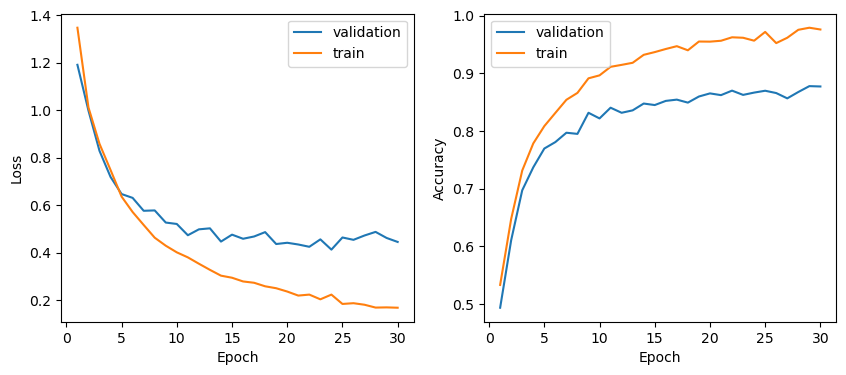

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train acc,▁▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇████████████
train loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
valid acc,▁▃▅▅▆▆▇▆▇▇▇▇▇▇▇██▇████████████
valid loss,█▆▅▄▃▃▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▂▂▁▁
epoch,29
train acc,0.976
train loss,0.16755
valid acc,0.8772
valid loss,0.44472


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [12]:
wandb.agent(sweep_id, train_wandb)

# Transfer Learning

## Load ResNet18

In [38]:
resnet18 = models.resnet18(weights=models.resnet.ResNet18_Weights.IMAGENET1K_V1)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Customize FC layer of ResNet18

In [39]:
class PreTrainedModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet18 = deepcopy(resnet18)
        in_features = resnet18.fc.in_features
        self.resnet18.fc = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=512),
            nn.ReLU(inplace=True),
            
            nn.Linear(in_features=512, out_features=128),
            nn.ReLU(inplace=True),
            
            nn.Linear(in_features=128, out_features=32),
            nn.ReLU(inplace=True),
            
            nn.Linear(in_features=32, out_features=num_classes)
        )
        
    def forward(self, x):
        return self.resnet18(x)
    
    def freeze(self):
        for param in self.resnet18.parameters():
            param.requires_grad = False
        for param in self.resnet18.fc.parameters():
            param.requires_grad = True
        
    def unfreeze(self):
        for param in self.resnet18.parameters():
            param.requires_grad = True

## Feature extraction
Freezing all weights except FC layer

In [40]:
sweep_config = {
    'method': 'bayes',
    'name': 'MIO_ConvNet_Freeze',
    'metric': {
        'goal': 'minimize', 
        'name': 'valid loss'
        },
    'parameters': {
        'lr': {
            'distribution': 'uniform',
            'min': 1e-4,
            'max': 7e-4
        }
     }
}

sweep_id = wandb.sweep(sweep_config, project='MIO ResNet18 Freeze')

Create sweep with ID: ncx07sbt
Sweep URL: https://wandb.ai/mhmdrz/MIO%20ResNet18%20Freeze/sweeps/ncx07sbt


In [41]:
def train_wandb_resnet18_freeze(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config

        resnet18_freeze = PreTrainedModel()
        resnet18_freeze.freeze()
        optimizer = optim.Adam(resnet18_freeze.parameters(), lr=config.lr, weight_decay=2e-4)
        train_model(resnet18_freeze, optimizer, epochs=20, print_every=-1, use_wandb=True)

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a6c2tpnh with config:
wandb: 	lr: 0.0003088602028974805


Epoch 1 / 20 -> Loss = 1.1481
Checking accuracy on validation set:
Got 2894 / 5000 correct (57.88 %)
----------------------------------------
Epoch 2 / 20 -> Loss = 0.8257
Checking accuracy on validation set:
Got 3045 / 5000 correct (60.90 %)
----------------------------------------
Epoch 3 / 20 -> Loss = 1.2953
Checking accuracy on validation set:
Got 3091 / 5000 correct (61.82 %)
----------------------------------------
Epoch 4 / 20 -> Loss = 0.9051
Checking accuracy on validation set:
Got 3094 / 5000 correct (61.88 %)
----------------------------------------
Epoch 5 / 20 -> Loss = 0.7284
Checking accuracy on validation set:
Got 3161 / 5000 correct (63.22 %)
----------------------------------------
Epoch 6 / 20 -> Loss = 0.8830
Checking accuracy on validation set:
Got 3195 / 5000 correct (63.90 %)
----------------------------------------
Epoch 7 / 20 -> Loss = 0.8559
Checking accuracy on validation set:
Got 3273 / 5000 correct (65.46 %)
----------------------------------------
Epoch 

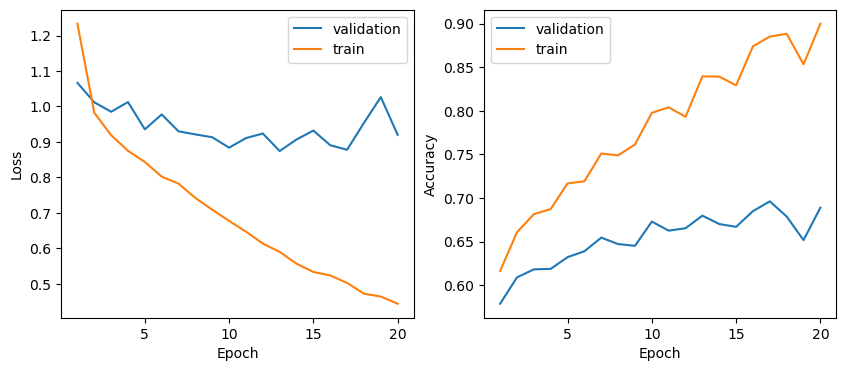

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train acc,▁▂▃▃▃▄▄▄▅▅▆▅▇▇▆▇██▇█
train loss,█▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
valid acc,▁▃▃▃▄▅▆▅▅▇▆▆▇▆▆▇█▇▅█
valid loss,█▆▅▆▃▅▃▃▂▁▂▃▁▂▃▂▁▄▇▃
epoch,19
train acc,0.89993
train loss,0.44366
valid acc,0.689
valid loss,0.92011


wandb: Agent Starting Run: rytpndqx with config:
wandb: 	lr: 0.00014431468057245534


Epoch 1 / 20 -> Loss = 1.2383
Checking accuracy on validation set:
Got 2710 / 5000 correct (54.20 %)
----------------------------------------
Epoch 2 / 20 -> Loss = 1.0884
Checking accuracy on validation set:
Got 2922 / 5000 correct (58.44 %)
----------------------------------------
Epoch 3 / 20 -> Loss = 0.9726
Checking accuracy on validation set:
Got 3003 / 5000 correct (60.06 %)
----------------------------------------
Epoch 4 / 20 -> Loss = 0.8190
Checking accuracy on validation set:
Got 3074 / 5000 correct (61.48 %)
----------------------------------------
Epoch 5 / 20 -> Loss = 0.8083
Checking accuracy on validation set:
Got 3116 / 5000 correct (62.32 %)
----------------------------------------
Epoch 6 / 20 -> Loss = 0.8065
Checking accuracy on validation set:
Got 3124 / 5000 correct (62.48 %)
----------------------------------------
Epoch 7 / 20 -> Loss = 1.0484
Checking accuracy on validation set:
Got 3130 / 5000 correct (62.60 %)
----------------------------------------
Epoch 

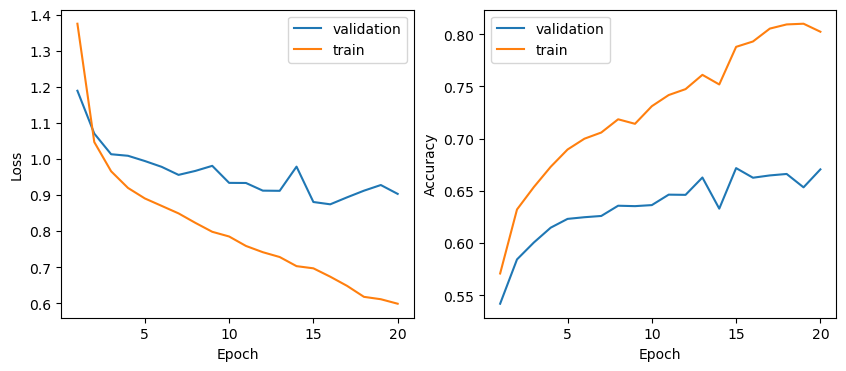

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train acc,▁▃▃▄▄▅▅▅▅▆▆▆▇▆▇█████
train loss,█▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
valid acc,▁▃▄▅▅▅▆▆▆▆▇▇█▆████▇█
valid loss,█▅▄▄▄▃▃▃▃▂▂▂▂▃▁▁▁▂▂▂
epoch,19
train acc,0.80233
train loss,0.59884
valid acc,0.6706
valid loss,0.90325


wandb: Agent Starting Run: tb41en4n with config:
wandb: 	lr: 0.00036665930321917245


Epoch 1 / 20 -> Loss = 0.8863
Checking accuracy on validation set:
Got 2954 / 5000 correct (59.08 %)
----------------------------------------
Epoch 2 / 20 -> Loss = 1.1025
Checking accuracy on validation set:
Got 3040 / 5000 correct (60.80 %)
----------------------------------------
Epoch 3 / 20 -> Loss = 0.8521
Checking accuracy on validation set:
Got 3133 / 5000 correct (62.66 %)
----------------------------------------
Epoch 4 / 20 -> Loss = 0.9569
Checking accuracy on validation set:
Got 3170 / 5000 correct (63.40 %)
----------------------------------------
Epoch 5 / 20 -> Loss = 1.0453
Checking accuracy on validation set:
Got 3191 / 5000 correct (63.82 %)
----------------------------------------
Epoch 6 / 20 -> Loss = 0.8460
Checking accuracy on validation set:
Got 3229 / 5000 correct (64.58 %)
----------------------------------------
Epoch 7 / 20 -> Loss = 0.5670
Checking accuracy on validation set:
Got 3296 / 5000 correct (65.92 %)
----------------------------------------
Epoch 

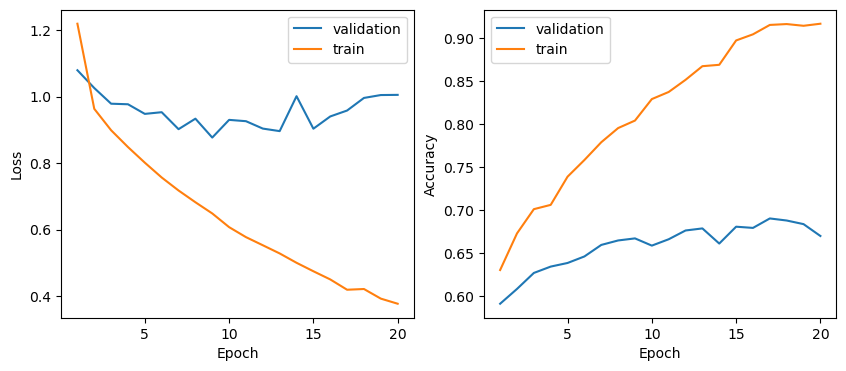

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train acc,▁▂▃▃▄▄▅▅▅▆▆▆▇▇██████
train loss,█▆▅▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁
valid acc,▁▂▄▄▄▅▆▆▆▆▆▇▇▆▇▇███▇
valid loss,█▆▅▄▃▄▂▃▁▃▃▂▂▅▂▃▄▅▅▅
epoch,19
train acc,0.91653
train loss,0.37692
valid acc,0.6696
valid loss,1.00507


wandb: Agent Starting Run: buwx31yl with config:
wandb: 	lr: 0.00032122235149406315


Epoch 1 / 20 -> Loss = 0.9416
Checking accuracy on validation set:
Got 2797 / 5000 correct (55.94 %)
----------------------------------------
Epoch 2 / 20 -> Loss = 0.9745
Checking accuracy on validation set:
Got 3047 / 5000 correct (60.94 %)
----------------------------------------
Epoch 3 / 20 -> Loss = 0.8987
Checking accuracy on validation set:
Got 3082 / 5000 correct (61.64 %)
----------------------------------------
Epoch 4 / 20 -> Loss = 1.2254
Checking accuracy on validation set:
Got 3123 / 5000 correct (62.46 %)
----------------------------------------
Epoch 5 / 20 -> Loss = 1.1669
Checking accuracy on validation set:
Got 3171 / 5000 correct (63.42 %)
----------------------------------------
Epoch 6 / 20 -> Loss = 0.7557
Checking accuracy on validation set:
Got 3223 / 5000 correct (64.46 %)
----------------------------------------
Epoch 7 / 20 -> Loss = 0.8796
Checking accuracy on validation set:
Got 3245 / 5000 correct (64.90 %)
----------------------------------------
Epoch 

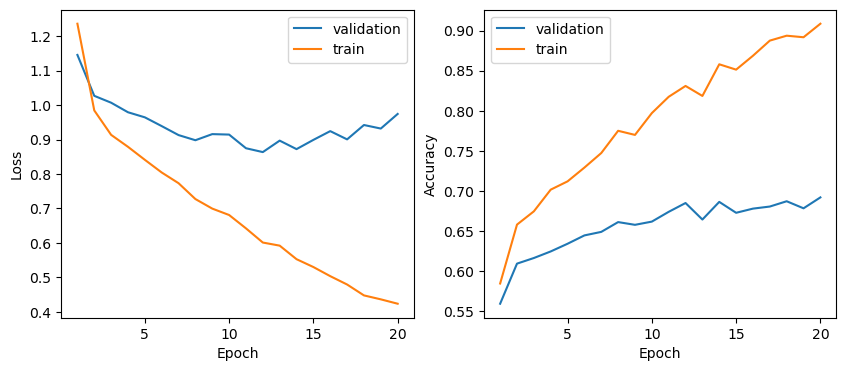

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train acc,▁▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇████
train loss,█▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁
valid acc,▁▄▄▄▅▅▆▆▆▆▇█▇█▇▇▇█▇█
valid loss,█▅▅▄▄▃▂▂▂▂▁▁▂▁▂▃▂▃▃▄
epoch,19
train acc,0.9086
train loss,0.42364
valid acc,0.692
valid loss,0.97417


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3aa69yfu with config:
wandb: 	lr: 0.0003749371819631893


Epoch 1 / 20 -> Loss = 0.9768
Checking accuracy on validation set:
Got 2944 / 5000 correct (58.88 %)
----------------------------------------
Epoch 2 / 20 -> Loss = 1.3302
Checking accuracy on validation set:
Got 3088 / 5000 correct (61.76 %)
----------------------------------------
Epoch 3 / 20 -> Loss = 1.1035
Checking accuracy on validation set:
Got 3129 / 5000 correct (62.58 %)
----------------------------------------
Epoch 4 / 20 -> Loss = 0.6371
Checking accuracy on validation set:
Got 3106 / 5000 correct (62.12 %)
----------------------------------------
Epoch 5 / 20 -> Loss = 1.0265
Checking accuracy on validation set:
Got 3193 / 5000 correct (63.86 %)
----------------------------------------
Epoch 6 / 20 -> Loss = 0.5953
Checking accuracy on validation set:
Got 3181 / 5000 correct (63.62 %)
----------------------------------------
Epoch 7 / 20 -> Loss = 0.8378
Checking accuracy on validation set:
Got 3322 / 5000 correct (66.44 %)
----------------------------------------
Epoch 

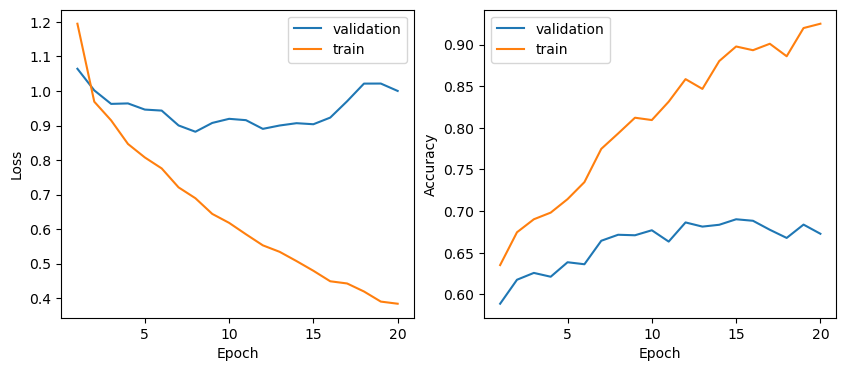

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train acc,▁▂▂▃▃▃▄▅▅▅▆▆▆▇▇▇▇▇██
train loss,█▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁
valid acc,▁▃▄▃▄▄▆▇▇▇▆█▇███▇▆█▇
valid loss,█▆▄▄▃▃▂▁▂▂▂▁▂▂▂▃▄▆▆▆
epoch,19
train acc,0.925
train loss,0.38418
valid acc,0.6728
valid loss,1.00025


In [42]:
wandb.agent(sweep_id, train_wandb_resnet18_freeze, count=5)

## Fine tune the full network
Let all weights to be updated

In [43]:
sweep_config = {
    'method': 'bayes',
    'name': 'MIO_ConvNet_Unfreeze',
    'metric': {
        'goal': 'minimize', 
        'name': 'valid loss'
        },
    'parameters': {
        'lr': {
            'distribution': 'uniform',
            'min': 1e-4,
            'max': 7e-4
        }
     }
}

sweep_id = wandb.sweep(sweep_config, project='MIO ResNet18 Unfreeze')

Create sweep with ID: 6unihpoi
Sweep URL: https://wandb.ai/mhmdrz/MIO%20ResNet18%20Unfreeze/sweeps/6unihpoi


In [44]:
def train_wandb_resnet18_unfreeze(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config

        resnet18_unfreeze = PreTrainedModel()
        resnet18_unfreeze.unfreeze()
        optimizer = optim.Adam(resnet18_unfreeze.parameters(), lr=config.lr, weight_decay=2e-4)
        train_model(resnet18_unfreeze, optimizer, epochs=20, print_every=-1, use_wandb=True)

wandb: Agent Starting Run: kx7chpaw with config:
wandb: 	lr: 0.0003035937129263179


Epoch 1 / 20 -> Loss = 0.2768
Checking accuracy on validation set:
Got 4329 / 5000 correct (86.58 %)
----------------------------------------
Epoch 2 / 20 -> Loss = 0.4367
Checking accuracy on validation set:
Got 4477 / 5000 correct (89.54 %)
----------------------------------------
Epoch 3 / 20 -> Loss = 0.0192
Checking accuracy on validation set:
Got 4502 / 5000 correct (90.04 %)
----------------------------------------
Epoch 4 / 20 -> Loss = 0.2321
Checking accuracy on validation set:
Got 4406 / 5000 correct (88.12 %)
----------------------------------------
Epoch 5 / 20 -> Loss = 0.5713
Checking accuracy on validation set:
Got 4524 / 5000 correct (90.48 %)
----------------------------------------
Epoch 6 / 20 -> Loss = 0.2355
Checking accuracy on validation set:
Got 4547 / 5000 correct (90.94 %)
----------------------------------------
Epoch 7 / 20 -> Loss = 0.0150
Checking accuracy on validation set:
Got 4547 / 5000 correct (90.94 %)
----------------------------------------
Epoch 

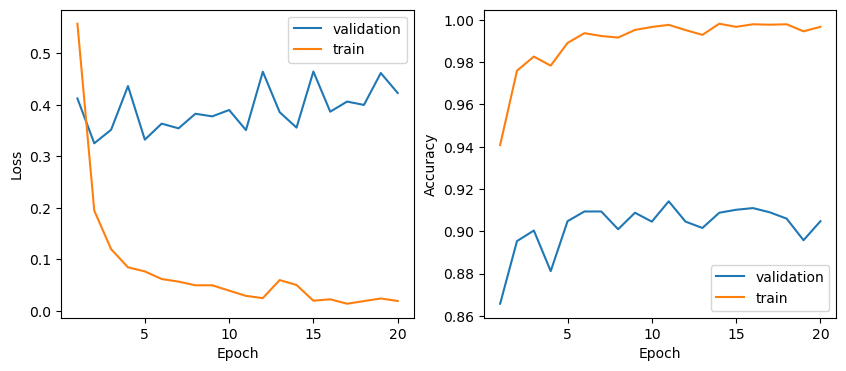

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train acc,▁▅▆▆▇▇▇▇████▇███████
train loss,█▃▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁
valid acc,▁▅▆▃▇▇▇▆▇▇█▇▆▇▇█▇▇▅▇
valid loss,▅▁▂▇▁▃▂▄▄▄▂█▄▃█▄▅▅█▆
epoch,19
train acc,0.99667
train loss,0.019
valid acc,0.9048
valid loss,0.42323


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: iiy0ysze with config:
wandb: 	lr: 0.0004110858963112193


Epoch 1 / 20 -> Loss = 0.4705
Checking accuracy on validation set:
Got 4351 / 5000 correct (87.02 %)
----------------------------------------
Epoch 2 / 20 -> Loss = 0.3322
Checking accuracy on validation set:
Got 4380 / 5000 correct (87.60 %)
----------------------------------------
Epoch 3 / 20 -> Loss = 0.1922
Checking accuracy on validation set:
Got 4366 / 5000 correct (87.32 %)
----------------------------------------
Epoch 4 / 20 -> Loss = 0.0748
Checking accuracy on validation set:
Got 4301 / 5000 correct (86.02 %)
----------------------------------------
Epoch 5 / 20 -> Loss = 0.9103
Checking accuracy on validation set:
Got 4443 / 5000 correct (88.86 %)
----------------------------------------
Epoch 6 / 20 -> Loss = 0.2086
Checking accuracy on validation set:
Got 4521 / 5000 correct (90.42 %)
----------------------------------------
Epoch 7 / 20 -> Loss = 0.2641
Checking accuracy on validation set:
Got 4381 / 5000 correct (87.62 %)
----------------------------------------
Epoch 

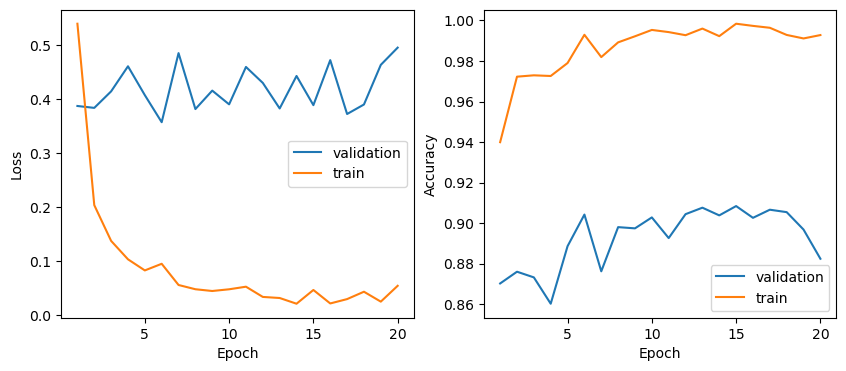

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train acc,▁▅▅▅▆▇▆▇▇██▇█▇███▇▇▇
train loss,█▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid acc,▂▃▃▁▅▇▃▆▆▇▆▇█▇█▇██▆▄
valid loss,▃▂▄▆▄▁▇▂▄▃▆▅▂▅▃▇▂▃▆█
epoch,19
train acc,0.9928
train loss,0.05408
valid acc,0.8824
valid loss,0.49561


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kssl9n9q with config:
wandb: 	lr: 0.0001855117151820275


Epoch 1 / 20 -> Loss = 0.5519
Checking accuracy on validation set:
Got 4207 / 5000 correct (84.14 %)
----------------------------------------
Epoch 2 / 20 -> Loss = 0.3835
Checking accuracy on validation set:
Got 4470 / 5000 correct (89.40 %)
----------------------------------------
Epoch 3 / 20 -> Loss = 0.5030
Checking accuracy on validation set:
Got 4480 / 5000 correct (89.60 %)
----------------------------------------
Epoch 4 / 20 -> Loss = 0.0953
Checking accuracy on validation set:
Got 4461 / 5000 correct (89.22 %)
----------------------------------------
Epoch 5 / 20 -> Loss = 0.0169
Checking accuracy on validation set:
Got 4479 / 5000 correct (89.58 %)
----------------------------------------
Epoch 6 / 20 -> Loss = 0.0083
Checking accuracy on validation set:
Got 4506 / 5000 correct (90.12 %)
----------------------------------------
Epoch 7 / 20 -> Loss = 0.2457
Checking accuracy on validation set:
Got 4511 / 5000 correct (90.22 %)
----------------------------------------
Epoch 

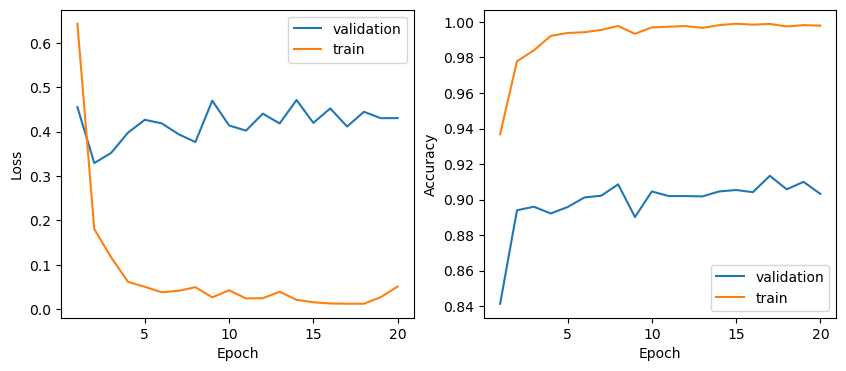

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train acc,▁▆▆▇▇▇██▇███████████
train loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid acc,▁▆▆▆▆▇▇█▆▇▇▇▇▇▇▇█▇█▇
valid loss,▇▁▂▄▆▅▄▃█▅▅▆▅█▅▇▅▇▆▆
epoch,19
train acc,0.99793
train loss,0.05127
valid acc,0.9032
valid loss,0.43056


wandb: Agent Starting Run: 749qk7w7 with config:
wandb: 	lr: 0.00017446029494528546


Epoch 1 / 20 -> Loss = 0.5548
Checking accuracy on validation set:
Got 4288 / 5000 correct (85.76 %)
----------------------------------------
Epoch 2 / 20 -> Loss = 0.2267
Checking accuracy on validation set:
Got 4395 / 5000 correct (87.90 %)
----------------------------------------
Epoch 3 / 20 -> Loss = 0.4137
Checking accuracy on validation set:
Got 4444 / 5000 correct (88.88 %)
----------------------------------------
Epoch 4 / 20 -> Loss = 0.6177
Checking accuracy on validation set:
Got 4419 / 5000 correct (88.38 %)
----------------------------------------
Epoch 5 / 20 -> Loss = 0.1287
Checking accuracy on validation set:
Got 4498 / 5000 correct (89.96 %)
----------------------------------------
Epoch 6 / 20 -> Loss = 0.0942
Checking accuracy on validation set:
Got 4504 / 5000 correct (90.08 %)
----------------------------------------
Epoch 7 / 20 -> Loss = 0.5686
Checking accuracy on validation set:
Got 4503 / 5000 correct (90.06 %)
----------------------------------------
Epoch 

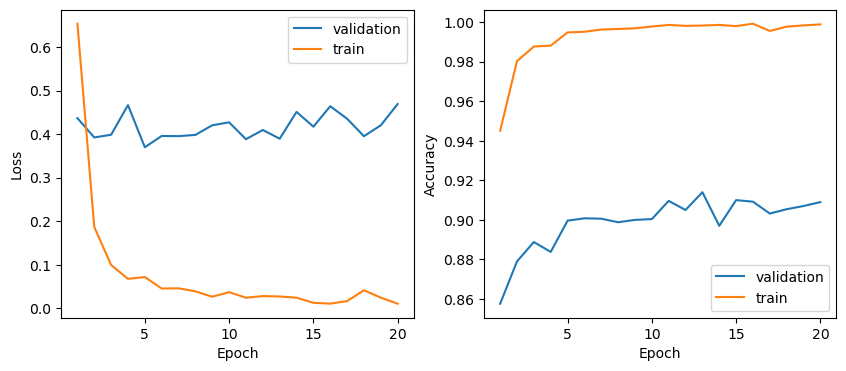

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train acc,▁▆▇▇▇▇██████████████
train loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid acc,▁▄▅▄▆▆▆▆▆▆▇▇█▆█▇▇▇▇▇
valid loss,▆▃▃█▁▃▃▃▅▅▂▄▂▇▄█▆▃▅█
epoch,19
train acc,0.99887
train loss,0.01064
valid acc,0.909
valid loss,0.46905


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: idbl0495 with config:
wandb: 	lr: 0.0004730137390443816


Epoch 1 / 20 -> Loss = 0.2803
Checking accuracy on validation set:
Got 4274 / 5000 correct (85.48 %)
----------------------------------------
Epoch 2 / 20 -> Loss = 0.0899
Checking accuracy on validation set:
Got 4415 / 5000 correct (88.30 %)
----------------------------------------
Epoch 3 / 20 -> Loss = 0.0590
Checking accuracy on validation set:
Got 4308 / 5000 correct (86.16 %)
----------------------------------------
Epoch 4 / 20 -> Loss = 0.3402
Checking accuracy on validation set:
Got 4454 / 5000 correct (89.08 %)
----------------------------------------
Epoch 5 / 20 -> Loss = 0.0867
Checking accuracy on validation set:
Got 4506 / 5000 correct (90.12 %)
----------------------------------------
Epoch 6 / 20 -> Loss = 0.0373
Checking accuracy on validation set:
Got 4514 / 5000 correct (90.28 %)
----------------------------------------
Epoch 7 / 20 -> Loss = 0.0081
Checking accuracy on validation set:
Got 4420 / 5000 correct (88.40 %)
----------------------------------------
Epoch 

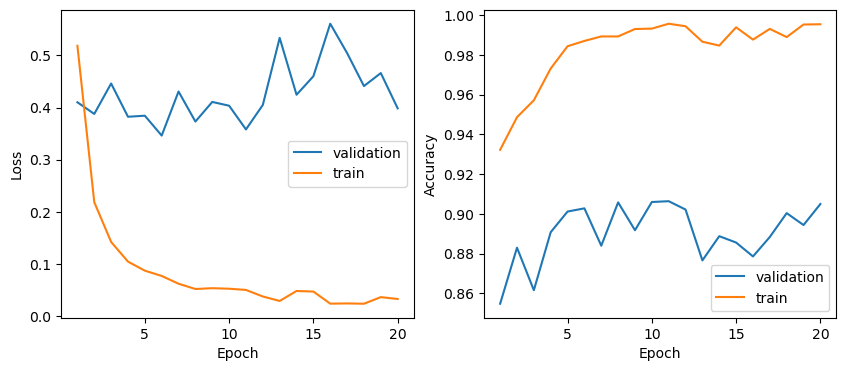

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train acc,▁▃▄▆▇▇▇▇████▇▇█▇█▇██
train loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
valid acc,▁▅▂▆▇█▅█▆██▇▄▆▅▄▆▇▆█
valid loss,▃▂▄▂▂▁▄▂▃▃▁▃▇▄▅█▆▄▅▃
epoch,19
train acc,0.99547
train loss,0.03272
valid acc,0.905
valid loss,0.39857


In [45]:
wandb.agent(sweep_id, train_wandb_resnet18_unfreeze, count=5)

# Choosing final model

Epoch 1 / 20 -> Loss = 0.1918
Checking accuracy on validation set:
Got 4278 / 5000 correct (85.56 %)
----------------------------------------
Epoch 2 / 20 -> Loss = 0.1072
Checking accuracy on validation set:
Got 4385 / 5000 correct (87.70 %)
----------------------------------------
Epoch 3 / 20 -> Loss = 0.2992
Checking accuracy on validation set:
Got 4506 / 5000 correct (90.12 %)
----------------------------------------
Epoch 4 / 20 -> Loss = 0.2452
Checking accuracy on validation set:
Got 4461 / 5000 correct (89.22 %)
----------------------------------------
Epoch 5 / 20 -> Loss = 0.3065
Checking accuracy on validation set:
Got 4486 / 5000 correct (89.72 %)
----------------------------------------
Epoch 6 / 20 -> Loss = 0.0136
Checking accuracy on validation set:
Got 4497 / 5000 correct (89.94 %)
----------------------------------------
Epoch 7 / 20 -> Loss = 0.6166
Checking accuracy on validation set:
Got 4454 / 5000 correct (89.08 %)
----------------------------------------
Epoch 

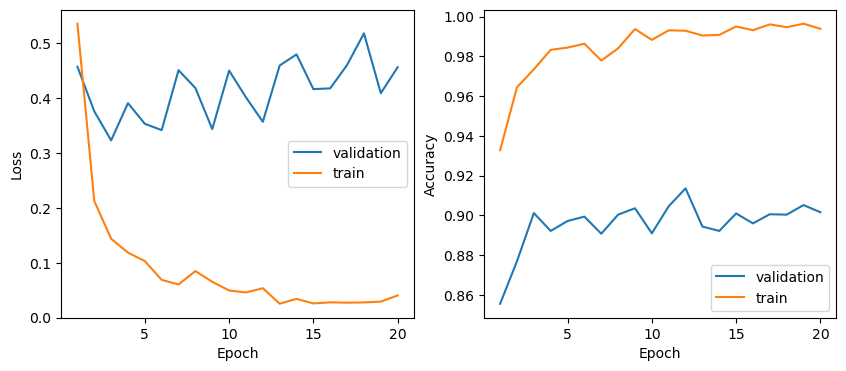

In [48]:
final_model = PreTrainedModel()
final_model.unfreeze()
optimizer = optim.Adam(final_model.parameters(), lr=0.0004730137390443816, weight_decay=2e-4)
train_model(final_model, optimizer, epochs=20, print_every=-1)

## Save model

In [62]:
torch.save(final_model.state_dict(), 'Model/final_resnet18.pth')

# Metric evaluation

## Training dataset

In [112]:
!python parse_classification_dataset.py "Dataset/train" "Results/my_result_train.csv" "Model/final_resnet18.pth"


Processing:  Dataset/train 




100%|##########| 5/5 [01:45<00:00, 21.17s/it]


In [114]:
!python classification_evaluation.py "Dataset/gt_train.csv" "Results/my_result_train.csv"

Computing score between  Dataset/gt_train.csv  and  Dataset/my_result_train.csv 

confusion matrix:
[[2993    3    0    0    4]
 [   2 2996    0    2    0]
 [   0    1 2996    3    0]
 [  33   13   24 2929    1]
 [   4    2    0    0 2994]]


cohen kappa score:
0.9923333333333333


precision score:
[0.9871372  0.99833278 0.99369818 0.99205298 0.99829584]


recall score:
[0.99766667 0.998      0.99866667 0.99866667 0.97633333]


f1 score:
[0.99237401 0.99816636 0.99617623 0.99534884 0.98719245]


mean recall:
0.9938666666666668


mean precision:
0.9939033957066121


mean f1:
0.9938515759924833


accuracy:
0.9938666666666667




## Validation dataset

In [115]:
!python parse_classification_dataset.py "Dataset/valid" "Results/my_result_valid.csv" "Model/final_resnet18.pth"


Processing:  Dataset/valid 




100%|##########| 5/5 [00:34<00:00,  6.90s/it]


In [116]:
!python classification_evaluation.py "Dataset/gt_valid.csv" "Results/my_result_valid.csv"

Computing score between  Dataset/gt_valid.csv  and  Dataset/my_result_valid.csv 

confusion matrix:
[[945  25   5   5  20]
 [ 16 964   2  13   5]
 [ 23  13 882  78   4]
 [ 99  53  61 755  32]
 [ 20  11   3   4 962]]


cohen kappa score:
0.877


precision score:
[0.85675431 0.94037146 0.9043152  0.92549843 0.88304094]


recall score:
[0.945 0.962 0.964 0.882 0.755]


f1 score:
[0.89871612 0.95106278 0.93320426 0.90322581 0.81401617]


mean recall:
0.9016


mean precision:
0.9019960643262405


mean f1:
0.9000450272556186


accuracy:
0.9016




## Test dataset

In [117]:
!python parse_classification_dataset.py "Dataset/test" "Results/my_result_test.csv" "Model/final_resnet18.pth"


100%|##########| 5/5 [00:34<00:00,  6.94s/it]



Processing:  Dataset/test 



In [118]:
!python classification_evaluation.py "Dataset/gt_test.csv" "Results/my_result_test.csv"

Computing score between  Dataset/gt_test.csv  and  Dataset/my_result_test.csv 

confusion matrix:
[[945  24   2   7  22]
 [ 28 954   0  14   4]
 [ 32  12 836 117   3]
 [ 98  40  49 789  24]
 [ 15   9   1   2 973]]


cohen kappa score:
0.87425


precision score:
[0.84525939 0.94834308 0.91819057 0.94144144 0.84930032]


recall score:
[0.945 0.973 0.954 0.836 0.789]


f1 score:
[0.89235127 0.96051333 0.93575282 0.88559322 0.81804044]


mean recall:
0.8994


mean precision:
0.9005069607832148


mean f1:
0.898450215469467


accuracy:
0.8994


